In [1]:
from dsc80_utils import *

# Lecture 10 - Web Scraping

## DSC 80, Fall 2023

## 📣 Announcements 📣

- Good job on the Midterm!
- Mid-quarter survey out, due **Thursday, Nov 9 at 11:59pm**.
    - https://forms.gle/khHDPRuhgTqZTW1e9
- Lab 6 released, due Monday.
- No discussion or OH on Friday (Veteran's Day).
- Project 3 released, due Friday, Nov 17.

## 📆 Agenda

- [ ] Review: Accessing HTML
- [ ] HTML basics
- [ ] Parsing HTML using BeautifulSoup
- [ ] Example: Scraping the HDSI faculty
- [ ] Example: Scraping quotes

## Review: Accessing HTML

**Goal**: Access information about HDSI faculty members from the HDSI Faculty page.

Let's start by making a `GET` request to the HDSI Faculty page and see what the resulting HTML looks like. 

In [2]:
import requests
r = requests.get('https://datascience.ucsd.edu/faculty/')
r

<Response [200]>

In [3]:
faculty_text = r.text
len(faculty_text)

270510

In [4]:
print(faculty_text[:1000])

<!DOCTYPE html>
<html lang="en-US">
<head>
    <meta charset="UTF-8">
	<meta name="viewport" content="width=device-width, initial-scale=1.0" />
	<meta http-equiv="X-UA-Compatible" content="IE=edge">
	<link rel="profile" href="https://gmpg.org/xfn/11" />
    <title>Faculty &#8211; Halıcıoğlu Data Science Institute &#8211; UC San Diego</title>
					<style type="text/css" id="cst_font_data">
						@font-face {
	font-family: 'Refrigerator Deluxe Extrabold';
	font-weight: 100;
	font-display: auto;
	font-fallback: Arial, Serif;
	src: url('https://datascience.ucsd.edu/wp-content/uploads/2023/03/Refrigerator-Deluxe-Extrabold.otf') format('OpenType');
}
@font-face {
	font-family: 'Refrigerator Deluxe Extrabold';
	font-weight: 100;
	font-display: auto;
	font-fallback: Arial, Serif;
	src: url('https://datascience.ucsd.edu/wp-content/uploads/2023/03/Refrigerator-Deluxe-Extrabold.otf') format('OpenType');
}
@font-face {
	font-family: 'Brix Sans Regular';
	font-weight: 400;
	font-display: auto;
	fon

In [5]:
'Samuel Lau' in faculty_text

False

Wow, that is gross looking! 😰 

- It is **raw** HTML, which web browsers use to display websites.
- The information we are looking for – faculty information – is in there somewhere, but we have to search for it and extract it, which we wouldn't have to do if we had an API.
- We'll now look at how HTML documents are structured and how to extract information from them.

### Best practices for scraping

1. **Send requests slowly** and be upfront about what you are doing!
2. Respect the policy published in the page's `robots.txt` file.
    - Many sites have a `robots.txt` file in their root directory, which contains a policy that allows or disallows automatic access to their site. 
3. Don't spoof your User-agent (i.e. don't try to trick the server into thinking you are a person).
4. Read the Terms of Service for the site and follow it.

### Consequences of irresponsible scraping

If you make too many requests:
* The server may block your IP Address.
* You may take down the website.
    - A journalist scraped and accidentally took down the Cook County Inmate Locater.
    - As a result, inmate's families weren't able to contact them while the site was down.

### Scraping vs. Using an API

- APIs: Made by organzation that hosts data
    - E.g. Twitter has an API (https://developer.twitter.com/en/docs/twitter-api)
    - Provides a code-friendly way to access data.
    - Get data as JSON (usually).
- Scraping: Your code emulates a web browser
    - Not supported by most organizations.
    - Get data as HTML.
    - Have to parse HTML to get the data you want.

## The anatomy of HTML documents

### What is HTML?

* HTML (HyperText Markup Language) is **the** basic building block of the internet. 
* It defines the content and layout of a webpage, and as such, it is what you get back when you scrape a webpage.
* See [this tutorial](https://developer.mozilla.org/en-US/docs/Learn/Getting_started_with_the_web/HTML_basics) for more details.

For instance, here's the content of a very basic webpage.

In [6]:
!cat data/lec10_ex1.html

<html>
  <head>
    <title>Page title</title>
  </head>

  <body>
    <h1>This is a heading</h1>
    <p>This is a paragraph.</p>
    <p>This is <b>another</b> paragraph.</p>
  </body>
</html>


Using `IPython.display.HTML`, we can render it directly in our notebook.

In [7]:
from IPython.display import HTML
from pathlib import Path
HTML(filename=Path('data') / 'lec10_ex1.html')

### The anatomy of HTML documents

* **HTML document**: The totality of markup that makes up a webpage.

* **Document Object Model (DOM)**: The internal representation of a HTML document as a hierarchical **tree** structure.

* **HTML element**: An object in the DOM, such as a paragraph, header, or title.
* **HTML tags**: Markers that denote the **start** and **end** of an element, such as `<p>` and `</p>`.

<center><img src='imgs/dom.jpg'></center>

<center><a href='https://simplesnippets.tech/what-is-document-object-modeldom-how-js-interacts-with-dom/'>(source)</a></center>

### Useful tags to know


|Element|Description|
|:---|:---|
|`<html>`|the document|
|`<head>`|the header|
|`<body>`|the body|
|`<div>` |a logical division of the document|
|`<span>`|an *inline* logical division|
|`<p>`|a paragraph|
| `<a>`| an anchor (hyperlink)|
|`<h1>, <h2>, ...`| header(s) |
|`<img>`| an image |

There are many, many more. See [this article](https://en.wikipedia.org/wiki/HTML_element) for examples.

### Example: images and hyperlinks

Tags can have **attributes**, which further specify how to display information on a webpage.

For instance, `<img>` tags have `src` and `alt` attributes (among others):

```html
<img src="king-selfie.png" alt="A photograph of King Triton." width=500>
```

Hyperlinks have `href` attributes: 

```html
Click <a href="https://dsc80.com/project3">this link</a> to access Project 3.
```

What do you think this webpage looks like?

In [8]:
!cat data/lec10_ex2.html

<html>
  <head>
    <title>Project 3 - DSC 80, Winter 2023</title>
    <link
      href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha1/dist/css/bootstrap.min.css"
      rel="stylesheet"
    />
  </head>

  <body>
    <h1>Project Overview</h1>
    <img src="../imgs/platter.png" width="200" alt="My dinner last night." />
    <p>
      Start Project 3 by cloning our
      <a href="https://github.com/dsc-courses/dsc80-2023-fa/"
        >public GitHub repo</a
      >. Note that there is <b>no checkpoint</b> for Project 3!
    </p>

    <center>
      <h3>
        Note that you'll have to submit your notebook as a PDF and a link to
        your website.
      </h3>
    </center>
  </body>
</html>


### The `<div>` tag

```html
<div style="background-color:lightblue">
  <h3>This is a heading</h3>
  <p>This is a paragraph.</p>
</div>
```

* The `<div>` tag defines a division or a "section" of an HTML document.
    * Think of a `<div>` as a "cell" in a Jupyter Notebook.

* The `<div>` element is often used as a container for other HTML elements to style them with CSS or to perform operations involving them using JavaScript.

* `<div>` elements often have attributes, **which are important when scraping**!

### Document trees

Under the document object model (DOM), HTML documents are trees. In DOM trees, child nodes are **ordered**.

<center>

<img src="imgs/webpage_anatomy.png" width="50%">

</center>    

What does the DOM tree look like for this document?

<center><img src="imgs/dom_tree.png" width="50%"></center>

## Parsing HTML using Beautiful Soup

### Beautiful Soup 🍜

* [Beautiful Soup 4](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) is a Python HTML parser.
    - To "parse" means to "extract meaning from a sequence of symbols".
* **Warning:** Beautiful Soup 4 and Beautiful Soup 3 work differently, so make sure you are using and looking at documentation for Beautiful Soup 4.

### Example HTML document

To start, we'll work with the source code for an HTML page with the DOM tree shown below:

<center><img src="imgs/dom_tree_1.png" width="50%"></center>

The string `html_string` contains an HTML "document".

In [35]:
html_string = '''
<html>
    <body>
      <div id="content">
        <h1>Heading here</h1>
        <p>My First paragraph</p>
        <p>My <em>second</em> paragraph</p>
        <hr>
      </div>
      <div id="nav">
        <ul>
          <li>item 1</li>
          <li>item 2</li>
          <li>item 3</li>
        </ul>
      </div>
    </body>
</html>
'''.strip()

In [36]:
HTML(html_string)

### `BeautifulSoup` objects

`bs4.BeautifulSoup` takes in a string or file-like object representing HTML (`markup`) and returns a **parsed** document.

In [37]:
import bs4

In [38]:
bs4.BeautifulSoup?

Normally, we pass the result of a `GET` request to `bs4.BeautifulSoup`, but here we will pass our hand-crafted `html_string`.

In [39]:
soup = bs4.BeautifulSoup(html_string)
soup

<html>
<body>
<div id="content">
<h1>Heading here</h1>
<p>My First paragraph</p>
<p>My <em>second</em> paragraph</p>
<hr/>
</div>
<div id="nav">
<ul>
<li>item 1</li>
<li>item 2</li>
<li>item 3</li>
</ul>
</div>
</body>
</html>

In [40]:
type(soup)

bs4.BeautifulSoup

`BeautifulSoup` objects have several useful attributes, e.g. `text`:

In [41]:
print(soup.text)




Heading here
My First paragraph
My second paragraph




item 1
item 2
item 3






### Traversing through `descendants`

The `descendants` attribute traverses a `BeautifulSoup` tree using **depth-first traversal**.

Why depth-first? Elements closer to one another on a page are more likely to be related than elements further away.

<center><img src="imgs/dom_tree_1.png" width="60%"></center>

In [42]:
soup.descendants

<generator object Tag.descendants at 0x7fd6c113aba0>

In [43]:
for child in soup.descendants:
#     print(child) # What would happen if we ran this instead?
    if isinstance(child, str):
        continue
    print(child.name)

html
body
div
h1
p
p
em
hr
div
ul
li
li
li


### Finding elements in a tree

Practically speaking, you will not use the `descendants` attribute (or the related `children` attribute) directly very often. Instead, you will use the following methods:

- `soup.find(tag)`, which finds the **first** instance of a tag (the first one on the page, i.e. the first one that DFS sees).
    - More general: `soup.find(name=None, attrs={}, recursive=True, text=None, **kwargs)`.
- `soup.find_all(tag)` will find **all** instances of a tag.


### Using `find`

Let's try and extract the first `<div>` subtree.

<center><img src="imgs/dom_tree_1.png" width="60%"></center>  

In [44]:
soup

<html>
<body>
<div id="content">
<h1>Heading here</h1>
<p>My First paragraph</p>
<p>My <em>second</em> paragraph</p>
<hr/>
</div>
<div id="nav">
<ul>
<li>item 1</li>
<li>item 2</li>
<li>item 3</li>
</ul>
</div>
</body>
</html>

In [45]:
div = soup.find('div')
div

<div id="content">
<h1>Heading here</h1>
<p>My First paragraph</p>
<p>My <em>second</em> paragraph</p>
<hr/>
</div>

<center><img src="imgs/dom_subtree_1.png" width="30%"></center>  

Let's try and find the `<div>` element that has an `id` attribute equal to `'nav'`.

In [46]:
soup.find('div', attrs={'id': 'nav'})

<div id="nav">
<ul>
<li>item 1</li>
<li>item 2</li>
<li>item 3</li>
</ul>
</div>

`find` will return the first occurrence of a tag, regardless of its depth in the tree.

In [21]:
soup.find('ul')

<ul>
<li>item 1</li>
<li>item 2</li>
<li>item 3</li>
</ul>

In [22]:
soup.find_all('li')

[<li>item 1</li>, <li>item 2</li>, <li>item 3</li>]

### Using `find_all`

`find_all` returns a list of all matches.

In [23]:
soup.find_all('div')

[<div id="content">
 <h1>Heading here</h1>
 <p>My First paragraph</p>
 <p>My <em>second</em> paragraph</p>
 <hr/>
 </div>,
 <div id="nav">
 <ul>
 <li>item 1</li>
 <li>item 2</li>
 <li>item 3</li>
 </ul>
 </div>]

In [24]:
soup.find_all('li')

[<li>item 1</li>, <li>item 2</li>, <li>item 3</li>]

In [25]:
[x.text for x in soup.find_all('li')]

['item 1', 'item 2', 'item 3']

### Node attributes
* The `text` attribute of a tag element gets the text between the opening and closing tags.
* The `attrs` attribute lists all attributes of a tag.
* The `get(key)` method gets the value of a tag attribute.

In [26]:
soup.find('p')

<p>My First paragraph</p>

In [27]:
soup.find('p').text

'My First paragraph'

In [28]:
soup.find('div')

<div id="content">
<h1>Heading here</h1>
<p>My First paragraph</p>
<p>My <em>second</em> paragraph</p>
<hr/>
</div>

In [29]:
soup.find('div').attrs

{'id': 'content'}

In [30]:
soup.find('div').get('id')

'content'

The `get` method must be called directly on the node that contains the attribute you're looking for.

In [31]:
soup

<html>
<body>
<div id="content">
<h1>Heading here</h1>
<p>My First paragraph</p>
<p>My <em>second</em> paragraph</p>
<hr/>
</div>
<div id="nav">
<ul>
<li>item 1</li>
<li>item 2</li>
<li>item 3</li>
</ul>
</div>
</body>
</html>

In [32]:
# While there are multiple 'id' attributes, none of them are in the <html> tag at the top.
soup.get('id')

In [33]:
soup.find('div').get('id')

'content'

## Example: Quote scraping

Consider the following webpage: https://quotes.toscrape.com/

<center><img src="imgs/quotes2scrape.png" width=60%></center>

- Goal: Extract quotes (and relevant metadata) into a dataframe.
- A good first step is to use the "inspect element" tool in our web browser.

Specifically, let's try to make a DataFrame that looks like the one below:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>quote</th>
      <th>author</th>
      <th>author_url</th>
      <th>tags</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</td>
      <td>Albert Einstein</td>
      <td>https://quotes.toscrape.com/author/Albert-Einstein</td>
      <td>change,deep-thoughts,thinking,world</td>
    </tr>
    <tr>
      <th>1</th>
      <td>“It is our choices, Harry, that show what we truly are, far more than our abilities.”</td>
      <td>J.K. Rowling</td>
      <td>https://quotes.toscrape.com/author/J-K-Rowling</td>
      <td>abilities,choices</td>
    </tr>
    <tr>
      <th>2</th>
      <td>“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”</td>
      <td>Albert Einstein</td>
      <td>https://quotes.toscrape.com/author/Albert-Einstein</td>
      <td>inspirational,life,live,miracle,miracles</td>
    </tr>
  </tbody>
</table>

### The plan

Eventually, we will create a single function – `make_quote_df` – which takes in an integer `n` and returns a **DataFrame** with the quotes on the **first `n` pages** of https://quotes.toscrape.com/.

To do this, we will define several helper functions:

- `download_page(i)`, which downloads a **single page** (page `i`) and returns a `BeautifulSoup` object of the response.

- `process_quote(div)`, which takes in a `<div>` tree corresponding to a **single quote** and returns a `dict` containing all of the relevant information for that quote.

- `process_page(divs)`, which takes in a list of `<div>` trees corresponding to a **single page** and returns a DataFrame containing all of the relevant information for all quotes on that page.

Key principle: some of our helper functions will make **requests**, and others will **parse**, but none will do both! 
- Easier to debug and catch errors.
- Avoids unnecessary requests.

### Downloading a single page

In [61]:
def download_page(i):
    url = f'https://quotes.toscrape.com/page/{i}'
    request = requests.get(url)
    return bs4.BeautifulSoup(request.text)

In `quote_df`, we will call `download_page` repeatedly – once for `i=1`, once for `i=2`, ..., `i = n`. For now, we will work with just page 1 (chosen arbitrarily).

In [62]:
soup = download_page(1)

### Parsing a single page

Let's look at the page's source code (via "inspect element") to find where the quotes in the page are located.

In [78]:
divs = soup.find_all('div', class_='quote')
# Shortcut for:
# divs = soup.find_all('div', attrs={'class': 'quote'})

In [79]:
divs[0]

<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
<a class="tag" href="/tag/change/page/1/">change</a>
<a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>
<a class="tag" href="/tag/thinking/page/1/">thinking</a>
<a class="tag" href="/tag/world/page/1/">world</a>
</div>
</div>

From this `<div>`, we can extract the quote, author name, author's URL, and tags.

In [80]:
divs[0].find('span', class_='text').text

'“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”'

In [81]:
divs[0].find('small', class_='author').text

'Albert Einstein'

In [82]:
divs[0].find('a').get('href')

'/author/Albert-Einstein'

In [83]:
divs[0].find('meta', class_='keywords').get('content')

'change,deep-thoughts,thinking,world'

Let's implement our next function, `process_quote`, which takes in a `<div>` corresponding to a single quote and returns a **dict** containing the quote's information.

- Why use a `dict`? Passing `pd.DataFrame()` a list of `dict`s is an easy way to create a dataframe.

In [85]:
def process_quote(div):
    quote = div.find('span', class_='text').text
    author = div.find('small', class_='author').text
    author_url = 'https://quotes.toscrape.com' + div.find('a').get('href')
    tags = div.find('meta', class_='keywords').get('content')
    
    return {'quote': quote, 'author': author, 'author_url': author_url, 'tags': tags}

In [86]:
process_quote(divs[3])

{'quote': '“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”',
 'author': 'Jane Austen',
 'author_url': 'https://quotes.toscrape.com/author/Jane-Austen',
 'tags': 'aliteracy,books,classic,humor'}

Our last helper function will take in a **list** of `<div>`s, call `process_quote` on each `<div>` in the list, and return a **DataFrame**.

In [87]:
def process_page(divs):
    return pd.DataFrame([process_quote(div) for div in divs])

In [88]:
process_page(divs)

,quote,author,author_url,tags
0,“The world as we have created it is a process ...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"change,deep-thoughts,thinking,world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,https://quotes.toscrape.com/author/J-K-Rowling,"abilities,choices"
2,“There are only two ways to live your life. On...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"inspirational,life,live,miracle,miracles"
...,...,...,...,...
7,"“I have not failed. I've just found 10,000 way...",Thomas A. Edison,https://quotes.toscrape.com/author/Thomas-A-Ed...,"edison,failure,inspirational,paraphrased"
8,“A woman is like a tea bag; you never know how...,Eleanor Roosevelt,https://quotes.toscrape.com/author/Eleanor-Roo...,misattributed-eleanor-roosevelt
9,"“A day without sunshine is like, you know, nig...",Steve Martin,https://quotes.toscrape.com/author/Steve-Martin,"humor,obvious,simile"


### Putting it all together

In [131]:
def make_quote_df(n):
    '''Returns a DataFrame containing the quotes on the first n pages of https://quotes.toscrape.com/.'''
    dfs = []
    for i in range(1, n + 1):
        # Download page n and create a BeautifulSoup object.
        soup = download_page(i)
        
        # Create DataFrame using the information in that page.
        divs = soup.find_all('div', class_='quote')
        df = process_page(divs)
        
        # Append DataFrame to dfs.
        dfs.append(df)
        
    # Stitch all DataFrames together.
    return pd.concat(dfs).reset_index(drop=True)

In [132]:
quotes = make_quote_df(3)
quotes.head()

,quote,author,author_url,tags
0,“The world as we have created it is a process ...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"change,deep-thoughts,thinking,world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,https://quotes.toscrape.com/author/J-K-Rowling,"abilities,choices"
2,“There are only two ways to live your life. On...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"inspirational,life,live,miracle,miracles"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,https://quotes.toscrape.com/author/Jane-Austen,"aliteracy,books,classic,humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,https://quotes.toscrape.com/author/Marilyn-Monroe,"be-yourself,inspirational"


The elements in the `'tags'` column are all strings, but they look like lists. This is not ideal, as we will see shortly.

## Example: Scraping the HDSI Faculty page

### Example

Let's try and extract a list of HDSI Faculty from https://datascience.ucsd.edu/faculty/.

- As usual, we start by opening our Developer Tools.
- As we can see, the HTML is much more complicated -- this is usually the case for websites in the wild.

In [93]:
fac_response = requests.get('https://datascience.ucsd.edu/faculty/')
fac_response

<Response [200]>

In [94]:
soup = bs4.BeautifulSoup(fac_response.text)

How do we get the `<div>`s that we want?

- Trial and error by adding / removing classes.

In [99]:
divs = soup.find_all(
    'div',
    # Too many!
    # class_='vc_clearfix',
    
    # Too few!
    # class_='vc_grid-term-faculty',
    
    # The right divs
    class_='vc_grid-item',
)

In [100]:
len(divs)

64

Within here, we need to extract each faculty member's name. It seems like names are stored as text within the `<h4>` tag.

In [102]:
divs[0].find('h4').text

'Henry Abarbanel'

We can also extract job titles:

In [106]:
divs[0].find(class_='pendari_people_title').text

'Distinguished Professor, HDSI Founding Faculty Member'

Let's create a DataFrame consisting of names and job titles for each faculty member.

In [109]:
names = [div.find('h4').text for div in divs]
names[:10]

['Henry Abarbanel',
 'Ilkay Altintas',
 'Tiffany Amariuta',
 'Mikio Aoi',
 'Ery Arias-Castro',
 'Vineet Bafna',
 'Mikhail Belkin',
 'Jelena Bradic',
 'Henrik Christensen',
 'Alex Cloninger']

In [111]:
titles = [div.find(class_='pendari_people_title').text for div in divs]
titles[:10]

['Distinguished Professor, HDSI Founding Faculty Member',
 'SDSC Chief Data Science Officer & HDSI Founding Faculty Fellow',
 'Assistant Professor',
 'Assistant Professor',
 'Professor',
 'Professor',
 'Professor',
 'Professor',
 'Distinguished Scientist, Professor',
 'Associate Professor']

In [113]:
faculty = pd.DataFrame({
    'name': names, 
    'title': titles, 
})
faculty.head()

,name,title
0,Henry Abarbanel,"Distinguished Professor, HDSI Founding Faculty..."
1,Ilkay Altintas,SDSC Chief Data Science Officer & HDSI Foundin...
2,Tiffany Amariuta,Assistant Professor
3,Mikio Aoi,Assistant Professor
4,Ery Arias-Castro,Professor


Now we have a DataFrame!

In [115]:
faculty[faculty['title'].str.contains('Teaching')]

,name,title
13,Justin Eldridge,Assistant Teaching Professor
14,Shannon Ellis,Associate Teaching Professor
29,Sam Lau,Assistant Teaching Professor
31,Soohyun Nam Liao,Assistant Teaching Professor


What if we want to get faculty members' pictures? 

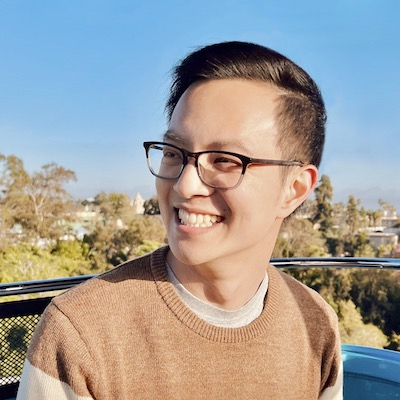

In [128]:
from IPython.display import Image, display
display(Image(divs[29].find('img')['src']))

## One-hot encoding

Let's take another look at the 'tags' column of the `quotes` dataframe:

In [134]:
quotes.head(2)

,quote,author,author_url,tags
0,“The world as we have created it is a process ...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"change,deep-thoughts,thinking,world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,https://quotes.toscrape.com/author/J-K-Rowling,"abilities,choices"


What if we wanted to know: how many quotes are tagged as `inspirational`?

- We can **flatten** lists of tags so that there is **one column per unique tag**.
    - For example, consider the tag `'inspirational'`.
    - If a quote has a 1 in the `'inspirational'` column, it **was** tagged `'inspirational'`.
    - If a quote has a 0 in the `'inspirational'` column, it **was not** tagged `'inspirational'`.
- This process – of converting categorical variables into columns of 1s and 0s – is called **one-hot encoding**. We will revisit it in a few weeks.

### One-hot encoded tags

In [140]:
tags = quotes['tags'].str.split(',')
tags

0           [change, deep-thoughts, thinking, world]
1                               [abilities, choices]
2     [inspirational, life, live, miracle, miracles]
                           ...                      
27                                                []
28                                     [imagination]
29                                           [music]
Name: tags, Length: 30, dtype: object

In [142]:
def encode(tag_list):
    return pd.Series({k: 1 for k in tag_list})

tags.apply(encode)

,change,deep-thoughts,thinking,world,...,fairy-tales,,imagination,music
0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
27,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN
28,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN
29,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0


Let's combine this one-hot-encoded DataFrame with `df`.

In [147]:
quotes_full = pd.concat([quotes, tags.apply(encode)], axis=1).drop(columns='tags')
quotes_full.head()

,quote,author,author_url,change,...,fairy-tales,,imagination,music
0,“The world as we have created it is a process ...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,1.0,...,NaN,NaN,NaN,NaN
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,https://quotes.toscrape.com/author/J-K-Rowling,NaN,...,NaN,NaN,NaN,NaN
2,“There are only two ways to live your life. On...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,NaN,...,NaN,NaN,NaN,NaN
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,https://quotes.toscrape.com/author/Jane-Austen,NaN,...,NaN,NaN,NaN,NaN
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,https://quotes.toscrape.com/author/Marilyn-Monroe,NaN,...,NaN,NaN,NaN,NaN


If we want all quotes tagged `'inspirational'`, we can simply query:

In [150]:
quotes_full.query('inspirational == 1')

,quote,author,author_url,change,...,fairy-tales,,imagination,music
2,“There are only two ways to live your life. On...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,NaN,...,NaN,NaN,NaN,NaN
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,https://quotes.toscrape.com/author/Marilyn-Monroe,NaN,...,NaN,NaN,NaN,NaN
7,"“I have not failed. I've just found 10,000 way...",Thomas A. Edison,https://quotes.toscrape.com/author/Thomas-A-Ed...,NaN,...,NaN,NaN,NaN,NaN
10,“This life is what you make it. No matter what...,Marilyn Monroe,https://quotes.toscrape.com/author/Marilyn-Monroe,NaN,...,NaN,NaN,NaN,NaN
16,"“The opposite of love is not hate, it's indiff...",Elie Wiesel,https://quotes.toscrape.com/author/Elie-Wiesel,NaN,...,NaN,NaN,NaN,NaN


## Web Data in Practice

[The spread of true and false news online](https://www.science.org/doi/full/10.1126/science.aap9559) by Vosoughi et al. compared how true and false news spreads via Twitter:

> There is worldwide concern over false news and the possibility that it can influence political, economic, and social well-being. To understand how false news spreads, Vosoughi et al. used a data set of rumor cascades on Twitter from 2006 to 2017. About 126,000 rumors were spread by ∼3 million people. False news reached more people than the truth; the top 1% of false news cascades diffused to between 1000 and 100,000 people, whereas the truth rarely diffused to more than 1000 people. Falsehood also diffused faster than the truth. The degree of novelty and the emotional reactions of recipients may be responsible for the differences observed.

- Twitter API for Twitter data.
- Web scraping for fact-checking websites.

## Summary, next time

- Beautiful Soup is an HTML parser that allows us to (somewhat) easily extract information from HTML documents.
    - `soup.find` and `soup.find_all` are the functions you will use most often.
- When writing scraping code:
    - Use "inspect element" to identify the names of tags and attributes that are relevant to the information you want to extract.
    - Separate your logic for making requests and for parsing.

### Next time

Regular expressions!